[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/adams/blob/master/exercises/tut4_NLP_pipeline_teacher.ipynb) 

# Manual Training Loop with tensorflow

So far we implemeneted (simplified version) of backpropagation in the 2. tutorial with a single weight, and a set of several weights (not weights matrices). Manually implementing backpropagation gives you full controll over the training process. However, the more complicated the architecture of the network is, the more difficult it would be to manually implement backprop. For this purpose, in the 3. tutorial we used the high-level api of keras, which is very simple and user-friendly: with several lines of code we trained and tuned our neural network. On the negative side, when using the high-level api, you have very little control over what is happening during the training process. Therefore, in this tutorial we will implement a manual training loop using tensorflow, which gives you more felxibility than the high-level api of keras and is not as code-intensive as manually implementing backprop. One of the advantages of building a manual training loop is that , among others, you can examine the flow of gradients during the training process. Keras provides an example implementation of such training loop: https://keras.io/guides/writing_a_training_loop_from_scratch/. Following the example online, and using the boston housing dataset from 3. tutorial or a dataset that you have simulated, implement manually the training loop. For simplicity reasons, you could use data consisting of single batch during the training process.  

In [6]:
import numpy as np
import tensorflow
from tensorflow.keras.datasets import boston_housing
import matplotlib.pyplot as plt
# this will split the data 80-20% by default
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [7]:
def tf_rmse(predictions, true_values):
    return tensorflow.math.sqrt(tensorflow.math.reduce_mean(tensorflow.math.square(tensorflow.math.subtract(predictions,true_values)),axis=0))

In [11]:
x_train_data=tensorflow.convert_to_tensor(x_train,dtype=tensorflow.float32)
y_train_data=tensorflow.convert_to_tensor(y_train,dtype=tensorflow.float32)
y_train_data=tensorflow.reshape(y_train_data,shape=(y_train_data.shape[0],1))

x_test_data=tensorflow.convert_to_tensor(x_test,dtype=tensorflow.float32)
y_test_data=tensorflow.convert_to_tensor(y_test,dtype=tensorflow.float32)
y_test_data=tensorflow.reshape(y_test_data,shape=(y_test_data.shape[0],1))


optimizer=tensorflow.keras.optimizers.Adam()
kernel_initializer=tensorflow.keras.initializers.HeNormal()
activation_function='relu'
units=50
nr_layers=10#will most probably overfit, but the point is to show how to build the manual loop, not build 
#the model for the task for now.
model=tensorflow.keras.Sequential([tensorflow.keras.layers.Dense(activation=activation_function,units=units,kernel_initializer=kernel_initializer) for nr_layer in range(0,nr_layers)])
model.add(tensorflow.keras.layers.Dense(units=1,activation='linear'))

nr_epochs=1
train_loss_epochs=[]
test_loss_epochs=[]

for epoch in range(0,nr_epochs):
    
    #predictions on train set:
    with tensorflow.GradientTape() as tape:
        predictions_train=model(x_train_data,training=True)
        train_loss=tf_rmse(predictions_train,y_train_data)
        train_loss_epochs.append(train_loss)
        
    gradients=tape.gradient(train_loss,model.trainable_variables)#backward pass
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    #print('After gradient updates on training data: ',model.trainable_variables[0][:10][:5])
    
    #predictions on test set:
    predictions_test=model(x_test_data,training=False)
    test_loss=tf_rmse(predictions_test,y_test_data)
    test_loss_epochs.append(test_loss)
    
    #print('After computation on testing data: ',model.trainable_variables[0][:10][:5])
    


In [79]:
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 50)                700       
                                                                 
 dense_133 (Dense)           (None, 50)                2550      
                                                                 
 dense_134 (Dense)           (None, 50)                2550      
                                                                 
 dense_135 (Dense)           (None, 50)                2550      
                                                                 
 dense_136 (Dense)           (None, 50)                2550      
                                                                 
 dense_137 (Dense)           (None, 50)                2550      
                                                                 
 dense_138 (Dense)           (None, 50)              

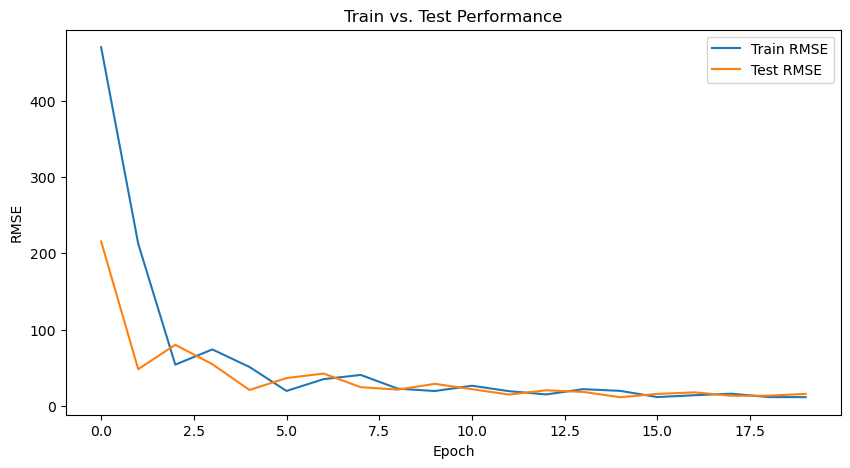

In [82]:
plt.figure(figsize=(10,5))
plt.plot(train_loss_epochs)
plt.plot(test_loss_epochs)
plt.legend(['Train RMSE','Test RMSE'])
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Train vs. Test Performance')
plt.show()
plt.close()

# NLP pipeline
You are already familiar with building predictive models on tabular data. In tabular data, you have a feature matrix `X` and a target vector `Y`. Given these data structures, you can apply learning algorithms to learn the relationship between `X` and `Y`. In this exercise, you are provided with a data set of movie reviews. Your goal is to build a classifier predicting whether a review has a positive or negative tone (this task is called sentiment classification). Hence, you have a prediction problem with a binary target, `Y`, which is nothing new for you. However, in this exercise, what is new for you is that you need to deal with text data instead of tabular data. With text data, you need to process the data to obtain the required feature matrix `X`. This processing of data is what we call the "NLP pipeline". 

In this exercise, you will need to set up an NLP pipeline. You are provided with a data set of movie reviews, where each sample contains a review (just a string cell). To obtain a feature matrix, each sample string cell needs to be transformed into a feature vector $x$. This process is called vectorization. There are multiple possible vectorization procedures. Today, you will implement a bag-of-words model for feature extraction. This feature extraction process involves two steps:
1. Vocabulary building
 * Tokenization: Transforming a review, which is a single string at the beginning, into a vector of strings (tokens).
 * Cleaning and compressing techniques: Reducing the number of distinct tokens. E.g., correcting the misspelling of words or lower casing the letters prevents the same word from appearing in multiple spelling ways. Additionally, similar words (e.g. different forms of a verb) can be united into a single token. 
 * Building a bag-of-words: a vector whose length corresponds exactly to the number of different tokens. Each token is assigned the position within the vector. 
 
2. Feature creation based on term frequency: Each review gets transformed into a feature vector $x$. The length of the feature vector corresponds to the length of the bag-of-words vector, created in step 1. An element $x_{j}$ of the feature vector is calculated by a frequency measure, measuring how frequently token $j$ from the bag-of-words vector occurs in the review. 

The first code cells provide the required packages and load the review data set, which you will use for the exercise. You will build the most simple NLP pipeline, which means that you go through steps 1 and 2 of the NLP pipeline, but you skip the "cleaning and compressing" part of step 1. This simple NLP pipeline provides you with a feature matrix `X` (possibly not ideal). You will use this feature matrix to build and evaluate a predictive model.

In the tutorial, we will extend your NLP pipeline by including the cleaning and compressing techniques (according techniques are also covered in detail in the demo notebook `nlp_foundations.ipynb`). That will lead to another feature matrix, `X`. Then, we will build another predictive model on this new feature matrix `X` and compare the performance to the model built by the simplified NLP pipeline.

In [1]:
# required packages
import pandas as pd
import nltk
# nltk.download('punkt') If needed
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup ## handles html
import re ## provides regular expressions functionality
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle

In [15]:
# Remeber to adjust the path so that it matches your environment
df = pd.read_csv("IMDB-50K-Movie-Review.zip", sep=",", encoding="ISO-8859-1")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [16]:
## get to know the data
print(df)
df.head()

                                                  review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [17]:
# Only use the first 10000 observations to reduce run time.
df = df.loc[0:10000,:]

df.reset_index(inplace=True, drop=True)  # dropping the index prohibits a reidentification of the cases in the original data frame
df.sentiment.value_counts()

positive    5028
negative    4973
Name: sentiment, dtype: int64

In [18]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
9996,Give me a break. How can anyone say that this ...,negative
9997,This movie is a bad movie. But after watching ...,negative
9998,This is a movie that was probably made to ente...,negative
9999,Smashing film about film-making. Shows the int...,positive


In [19]:
# Map label
df['sentiment'] = df['sentiment'].map({'positive' : 1, 'negative': 0})
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Simple NLP pipeline:
You need to transform the text data, contained in the column `df["review"]`, such that it is suitable as a feature matrix `X`, which you need for predictive model building. This means in detail: 

a) Create a list "reviews_tokenized", where each element corresponds to a string vector, representing a review. Use NLTK's `word_tokenize()` function. In case you get error messages from nltk, follow the instructions from the error to resolve it.

In [26]:
nltk.download('punkt')
nltk.word_tokenize('Hello World')

['Hello', 'World']

In [27]:
reviews_tokenized = df.apply(lambda row: nltk.word_tokenize(row['review']), axis=1)
print(reviews_tokenized)

0        [One, of, the, other, reviewers, has, mentione...
1        [A, wonderful, little, production, ., <, br, /...
2        [I, thought, this, was, a, wonderful, way, to,...
3        [Basically, there, 's, a, family, where, a, li...
4        [Petter, Mattei, 's, ``, Love, in, the, Time, ...
                               ...                        
9996     [Give, me, a, break, ., How, can, anyone, say,...
9997     [This, movie, is, a, bad, movie, ., But, after...
9998     [This, is, a, movie, that, was, probably, made...
9999     [Smashing, film, about, film-making, ., Shows,...
10000    [``, While, sporadically, engrossing, (, inclu...
Length: 10001, dtype: object


b) Split the review data (`reviews_tokenized`) as well as the target `df['sentiment']` in training and test sets. Use 80% of the data for training. Use sklearn's `train_test_split()` function.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(reviews_tokenized, df['sentiment'], test_size = 0.2, random_state = 5)

c) Now, we need to set up a vocabulary for all tokens and apply this vocabulary to obtain feature vectors $x$. We do this using sklearn's `TfidfVectorizer`. Feel free to experiment with other feature engineering methods from the lecture, f.e., term frequency matrix (in sklearn `CountVectorizer`). You need to apply the vectorizer to the data.

In [30]:
def dummy_fun(doc):
    return doc  

vectorizer = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = dummy_fun,
    preprocessor = dummy_fun,
    token_pattern = None)

## Set up the dictionary and calculate the document frequency of each token on the training set.
## Then generate the features on the training set, using the document frequency table.
reviews_tr = vectorizer.fit_transform(X_train)

## Apply the document frequency table on the test set, to generate feature vectors.
reviews_ts = vectorizer.transform(X_test)

The `TfidfVectorizer` did multiple steps at once. To better understand how it works, you should examine the results step by step.

d) Examine the vocabulary it created: How many tokens does it include? Which tokens are included? Would it maybe be better to leave some of these tokens out to reduce the dimension of the vocabulary and the derived feature matrix?

In [31]:
# vocab = vectorizer.get_feature_names()
vocab = vectorizer.get_feature_names_out()
print('The vocabulary contains ' + str(len(vocab)) + ' tokens.')
print('Now let us look at some examples of these tokens.')
print(vocab[0:50])

The vocabulary contains 73441 tokens.
Now let us look at some examples of these tokens.
['\x10own' '!' '#' '$' '%' '&' "'" "''" "'." "'007" "'00s" "'01" "'02"
 "'03" "'04" "'05" "'06" "'07" "'10" "'12" "'15" "'1st" "'20th" "'28"
 "'30" "'30s" "'30s-'40s" "'30s-Ray" "'30s/'40s" "'40" "'40s" "'42" "'43"
 "'45" "'50" "'50s" "'50s/early" "'51" "'54-'55" "'59" "'60" "'60s"
 "'60s-early" "'61" "'63" "'66" "'68" "'69" "'70" "'70's-style"]


e) Let's recap how feature vectors are generated from this vocabulary. The basic idea of bag-of-words based feature extraction is to generate for each token in the vocabulary a column in the feature matrix `X`. For an observation $i$ (corresponding to a single review), the entry $X_{i,j}$ of the feature matrix would be 1 if the review contains the token of column $j$ and 0 otherwise. There are some variations to this approach, f.e., the Tfidf approach (*term frequency-inverse document frequency*), which we apply in this exercise. Have a look at the matrix, which the `TfidfVectorizer` created. 

In [32]:
## print the first 100 feature entries for the first review
print(reviews_tr[0,0:100].todense())
print(X_train[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.07425346 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

f) Fit a logistic regression classifier and evaluate the accuracy of the predictions on the training and test sets.

In [37]:
classifier = LogisticRegression()
classifier.fit(reviews_tr, y_train)
pred_test = classifier.predict(reviews_ts)
pred_train = classifier.predict(reviews_tr)
print(metrics.accuracy_score(y_train, pred_train))
print(metrics.accuracy_score(y_test, pred_test))

0.936
0.847576211894053


## Extended NLP Excercise
In the previous exercise, we took little care about the cleaning and compressing part of the NLP pipeline. As a consequence, we obtained a dictionary with a lot of tokens which are most likely not so informative. The high number of tokens in the dictionary resulted in a very high dimension of the feature matrix `X`. In this exercise, we will add the cleaning and compressing part to the NLP pipeline. We hope to create a feature matrix of lower dimension, which yields more accurate predictions.

In [15]:
## download pre-learned NLP tools
nltk.download('stopwords') ## to identify stopwords 
nltk.download('averaged_perceptron_tagger') ## for part-of-speech tagging (used for lemmatization)
nltk.download('omw-1.4')
nltk.download('wordnet')

# Lemmatize with POS Tag (Parts of Speech tagging)
def get_wordnet_pos(word):
    """Map POS tag to first character for lemmatization"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

## function to clean text data
def clean_reviews(df):
    """ Standard NLP pre-processing chain including removal of html tags, non-alphanumeric characters, and stopwords.
        Words are subject to lemmatization using their POS tags, which are determind using WordNet. 
    """
    reviews = []

    lemmatizer = WordNetLemmatizer()
    
    print('*' * 40)
    print('Cleaning {} movie reviews.'.format(df.shape[0]))
    counter = 0
    for review in df:
        
        # remove html content
        review_text = BeautifulSoup(review).get_text()
        
        # remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        # tokenize the sentences with all capital letters transformed to lower case
        words = word_tokenize(review_text.lower())
  
        # filter stopwords
        words = [w for w in words if w not in stopwords.words("english")]
        
        # lemmatize each word to its lemma
        lemma_words =[lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in words]
    
        reviews.append(lemma_words)
              
        if (counter > 0 and counter % 500 == 0):
            print('Processed {} reviews'.format(counter))
            
        counter += 1
        
    print('DONE')
    print('*' * 40)

    return(reviews) 

[nltk_data] Downloading package stopwords to C:\Users\Georg
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Georg Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Georg
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Georg
[nltk_data]     Velev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [42]:
#* Do the cleaning
# CAUTION: takes around 20 minutes 
reviews_clean = clean_reviews(df.review)

****************************************
Cleaning 10001 movie reviews.
Processed 500 reviews


C:\Users\Georg Velev\anaconda3\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


Processed 1000 reviews
Processed 1500 reviews
Processed 2000 reviews
Processed 2500 reviews
Processed 3000 reviews
Processed 3500 reviews
Processed 4000 reviews
Processed 4500 reviews
Processed 5000 reviews
Processed 5500 reviews
Processed 6000 reviews
Processed 6500 reviews
Processed 7000 reviews
Processed 7500 reviews
Processed 8000 reviews
Processed 8500 reviews
Processed 9000 reviews
Processed 9500 reviews
Processed 10000 reviews
DONE
****************************************


In [43]:
with open('clean_reviews.pkl', 'wb') as f:
    pickle.dump(reviews_clean,f)

In [45]:
## load cleaned data
with open('clean_reviews.pkl', 'rb') as f:
    reviews_clean=pickle.load(f)


**Preprocessing steps for textual data**

a) eliminating HTML characters:

In [23]:
html_text='<p>I am a paragraph, oh yes I am.</p>'#https://developer.mozilla.org/en-US/docs/Learn/HTML/Introduction_to_HTML/HTML_text_fundamentals
print('Original HTML text: ',html_text)
print('AFter applying BS: ',BeautifulSoup(html_text).get_text())

Original HTML text:  <p>I am a paragraph, oh yes I am.</p>
AFter applying BS:  I am a paragraph, oh yes I am.


In [24]:
html_text='<span style="font-size: 32px; margin: 21px 0; display: block;"> Is this a top level heading? </span>'
BeautifulSoup(html_text).get_text()

' Is this a top level heading? '

b) eliminating special characters:
- check out the rules for matching substrings: https://docs.python.org/3/library/re.html

In [37]:
special_characters_text='I decided to go to the event on 25.01.23!'
print(re.sub("[^a-zA-Z]"," ", special_characters_text))
#^: all characters not in the set of a,A-z,Z will be matched!
print(re.sub("[a-zA-Z]"," ", special_characters_text))
print(re.sub("[1-3]"," ", special_characters_text))
print(re.sub("!"," ", special_characters_text))

I decided to go to the event on          
                                25.01.23!
I decided to go to the event on  5.0 .  !
I decided to go to the event on 25.01.23 


c) lemmatizing words to their dictionary form: f.e., using WordNetLemmatizer
- uses wordnet database: https://wordnet.princeton.edu/
- over the years the database continuously extended
- words grouped together based on their semantic similarity, meaning if they are synonyms.
- the groups: called synsets
- check out the search functionality: http://wordnetweb.princeton.edu/perl/webwn?o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&s=banking&h=0000000000&j=0#c 
- part-of-speech tag improves the lemmatization. 

In [13]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('auctioned'))
print(lemmatizer.lemmatize('auctioned','v'))
#it is a powerful tool for text normalization, since it allows normalization to occur in a more syntactical manner 
#(verbs continue being verbs, nouns continue being nouns and so on, if recognized as such, which is not always the case).

auctioned
auction


In [22]:
## While the text gets cleaned, we have a look at the part-of-speech-tagging and lemmatization part of the cleaning function
## part-of-speech tagging identifies the word category (whether a word is a verb, noun, adjective, or adverb)
print(get_wordnet_pos('running'))
print(get_wordnet_pos('runner'))
print(get_wordnet_pos('runed'),'\n')


## the word categorie determines how to lemmatize the word
print(lemmatizer.lemmatize('running',get_wordnet_pos('running')))
print(lemmatizer.lemmatize('runner',get_wordnet_pos('runner')))

print(lemmatizer.lemmatize('runed',get_wordnet_pos('runed')))#incorrect words:
print(lemmatizer.lemmatize('runed'))

v
n
v 

run
runner
run
runed


**Train-Test Split and building Tf-Idf Matrix**

In [47]:
## split reviews in training and test set
Xclean_train, Xclean_test, y_train, y_test = train_test_split(reviews_clean, df['sentiment'], test_size = 0.2, random_state = 5)

In [48]:
## apply tfidf feature extraction
vectorizer_clean = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = dummy_fun,
    preprocessor = dummy_fun,
    token_pattern = None)

## apply tfidf to training set and create vocabulary
reviews_clean_tr = vectorizer_clean.fit_transform(Xclean_train)

## Apply the document frequency table one the test set, to generate feature vectors.
reviews_clean_ts = vectorizer_clean.transform(Xclean_test)

In [49]:
## analyze vocabulary
vocab_clean = vectorizer_clean.get_feature_names_out()
print('The vocabulary contains ' + str(len(vocab_clean)) + ' tokens.')
print('Now let us look at some examples of these tokens.')
# print(vocab_clean[10000:10050])
print(vocab_clean[0:50])

The vocabulary contains 38070 tokens.
Now let us look at some examples of these tokens.
['aa' 'aaa' 'aaaaahhhh' 'aaaarrgh' 'aaah' 'aaall' 'aaargh' 'aaaugh' 'aag'
 'aah' 'aaip' 'aaliyah' 'aames' 'aamir' 'aamto' 'aankhen' 'aap' 'aardman'
 'aaron' 'aarp' 'aashok' 'aatish' 'aavjo' 'aawip' 'ab' 'abandon'
 'abandonment' 'abash' 'abba' 'abbey' 'abbie' 'abbot' 'abbott'
 'abbreviate' 'abc' 'abdalla' 'abdic' 'abdomen' 'abduct' 'abductee'
 'abduction' 'abductor' 'abducts' 'abdul' 'abe' 'abedded' 'abel'
 'abemethie' 'abernathie' 'abernethie']


**Training the model with cleaned data**

In [50]:
## apply and evaluate classifier on clean text data
classifier_clean = LogisticRegression()
classifier_clean.fit(reviews_clean_tr, y_train)
pred_test = classifier_clean.predict(reviews_clean_ts)
pred_train = classifier_clean.predict(reviews_clean_tr)
print(metrics.accuracy_score(y_train, pred_train))
print(metrics.accuracy_score(y_test, pred_test))

0.94575
0.863568215892054
